In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut
from sklearn.model_selection import cross_val_score
from sklearn.cross_decomposition import PLSRegression

In [40]:
def get_feature_matrix(masstime, data, significant=True):
    if not significant:
        return data.iloc[3:,8:].to_numpy(dtype=float).T
    inds=[]
    for i in range(3,data.shape[0]):
        mt=data.iloc[i,4] + '@' + data.iloc[i,5]
        if mt in masstime:
            inds.append(i)
    inds=np.unique(np.asarray(inds, dtype=int))
    return data.iloc[inds,8:].to_numpy(dtype=float).T

def get_features(masstime, data, significant=True):
    if not significant:
        return data
    inds=[0,1,2]
    for i in range(3,data.shape[0]):
        mt=data.iloc[i,4] + '@' + data.iloc[i,5]
        if mt in masstime:
            inds.append(i)
    inds=np.unique(np.asarray(inds, dtype=int))
    return data.iloc[inds,:]


def get_ids(data):
    ID=[]
    for line in data.iloc[2,8:]:
        ID.append(line.split('_')[-1].split('.')[0])
    return np.array(ID)

def add_noise(x, magnitude):
    return x + np.random.normal(0,magnitude, x.shape)

def make_oneWay_design(covariates):
    LE = LabelEncoder()
    codes = LE.fit_transform(covariates)
    levels = np.unique(codes)
    k = len(levels)
    n = len(codes)
    
    design = np.zeros((n,k))
    mapping = []
    for j in range(k):
        for i in range(n):
            mapping.append(levels[j])
            design[i,j] = (codes[i]==levels[j])
            
    return design, LE.inverse_transform(levels)

In [81]:
path_s = "../../PDproj/cellresults/ttest/ALPHA0.05FC1.0MINVAR0.125/"
filenames_s = [line.split('\n')[0] for line in open(path_s + "filenames.txt")]
filenames_s

['cellshilicneg_log2.csvALPHA0.05FC1.0MINVAR0.125.csv',
 'cellshilicpos_log2.csvALPHA0.05FC1.0MINVAR0.125.csv',
 'cellslipidomicsneg_log2.csvALPHA0.05FC1.0MINVAR0.125.csv',
 'cellslipidomicspos_log2.csvALPHA0.05FC1.0MINVAR0.125.csv',
 'cellsRPneg_log2.csvALPHA0.05FC1.0MINVAR0.125.csv',
 'cellsRPpos_log2.csvALPHA0.05FC1.0MINVAR0.125.csv',
 'mediumHILICneg_log2.csvALPHA0.05FC1.0MINVAR0.125.csv',
 'mediumHILICpos_log2.csvALPHA0.05FC1.0MINVAR0.125.csv',
 'mediumRPneg_log2.csvALPHA0.05FC1.0MINVAR0.125.csv',
 'mediumRPpos_log2.csvALPHA0.05FC1.0MINVAR0.125.csv']

In [105]:
path_s2 = "../../PDproj/cellresults/ttest/withGF/ALPHA0.05FC1.0MINVAR0.125/"
filenames_s2 = [line.split('\n')[0] for line in open(path_s2 + "filenames.txt")]
filenames_s2

['cellshilicnegALPHA0.05FC1.0MINVAR0.125.csv',
 'cellshilicposALPHA0.05FC1.0MINVAR0.125.csv',
 'cellslipidnegALPHA0.05FC1.0MINVAR0.125.csv',
 'cellslipidposALPHA0.05FC1.0MINVAR0.125.csv',
 'cellsRPnegALPHA0.05FC1.0MINVAR0.125.csv',
 'cellsRPposALPHA0.05FC1.0MINVAR0.125.csv',
 'mediumhilicnegALPHA0.05FC1.0MINVAR0.125.csv',
 'mediumhilicposALPHA0.05FC1.0MINVAR0.125.csv',
 'mediumRPnegALPHA0.05FC1.0MINVAR0.125.csv',
 'mediumRPposALPHA0.05FC1.0MINVAR0.125.csv']

In [106]:
path = "../../PDproj/celldata/clean/"
filenames = [line.split('\n')[0] for line in open(path + "filenames.txt")]
filenames

['cellshilicneg_log2.csv',
 'cellshilicpos_log2.csv',
 'cellslipidomicsneg_log2.csv',
 'cellslipidomicspos_log2.csv',
 'cellsRPneg_log2.csv',
 'cellsRPpos_log2.csv',
 'mediumHILICneg_log2.csv',
 'mediumHILICpos_log2.csv',
 'mediumRPneg_log2.csv',
 'mediumRPpos_log2.csv']

In [107]:
fnum=2 # 2 is good example
data = pd.read_csv(path + filenames[fnum], sep=';', header=None)
tle = filenames[fnum].split('_')[0]
df = pd.read_csv(path_s + filenames_s[fnum],sep=';')
df_GF = pd.read_csv(path_s2 + filenames_s2[fnum],sep=';')

In [108]:
print(filenames[fnum])
print(filenames_s[fnum])
print(filenames_s2[fnum])

cellslipidomicsneg_log2.csv
cellslipidomicsneg_log2.csvALPHA0.05FC1.0MINVAR0.125.csv
cellslipidnegALPHA0.05FC1.0MINVAR0.125.csv


### Get significant features with GAP status

In [103]:
fnum=2
pathGF = "../../PDproj/celldata/datawithGFstatus/clean/"
filenamesGF = [line.split('\n')[0] for line in open(pathGF + "filenames.txt")]
print(filenamesGF[fnum])
data = pd.read_csv(pathGF + filenamesGF[fnum],sep=';', header=None)

path_s2 = "../../PDproj/cellresults/ttest/withGF/ALPHA0.05FC1.0MINVAR0.125/"
filenames_s2 = [line.split('\n')[0] for line in open(path_s2 + "filenames.txt")]
print(filenames_s2[fnum])
df_select = pd.read_csv(path_s2 + filenames_s2[fnum],sep=';')

masstime = np.unique(df_select[' masstime'].to_numpy())
GF=get_features(masstime, data, True)
GFcols = [i for i in range(0,GF.shape[1]) if i not in np.arange(8,88)]
GF=GF.iloc[:,GFcols]
Area = GF.iloc[3:,8:48]
Area_all = data.iloc[3:,8:48]
groups = data.iloc[0,8:48]
LE = LabelEncoder()
labels = LE.fit_transform(groups)

cellslipidnegGFstatus.csv
cellslipidnegALPHA0.05FC1.0MINVAR0.125.csv


In [91]:
design, levels = make_oneWay_design(groups)

In [94]:
x=Area_all.to_numpy().T
#feats = x[:,np.random.choice(np.arange(x.shape[1]),40)]
feats = PCA(n_components=20).fit_transform(x) 
#feats = x

In [95]:
logreg = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=1,C=0.1).fit(feats, labels)
logreg.score(feats, labels)

0.675

In [96]:
logreg.score(feats, labels)

0.675

In [97]:
tsne=TSNE().fit_transform(feats)

/opt/software/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/software/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


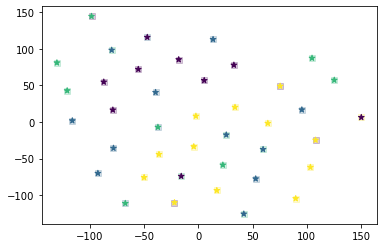

In [98]:
plt.scatter(tsne[:,0],tsne[:,1],c=labels,marker='s', alpha=0.2)
plt.scatter(tsne[:,0],tsne[:,1],c=logreg.predict(feats),marker='*')

### Check GAP fill patterns

In [290]:
aSYN=GF.iloc[:,8:18]
comb=GF.iloc[:,18:28]
INFg=GF.iloc[:,28:38]
UT=GF.iloc[:,38:]

In [291]:
tol=10
token=8
inds=[]
ls=['aSYN','comb','INFg','UT']
for k, group in enumerate([aSYN,comb,INFg,UT]):
    for i in range(3,group.shape[0]):
        arr=np.asarray(group.iloc[i,:], dtype=int)
        s=np.sum(arr==token)
        if s>=tol:
            inds.append((ls[k],i))

### Get significant features by matching masstimes

In [89]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,aSYN,aSYN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Name,Formula,Annot. DeltaMass [ppm],Calc. MW,m/z,RT [min],MS2,Reference Ion,Area: 221005_SarkaLehtonen_Hilic_neg_0088.raw ...,Area: 221005_SarkaLehtonen_Hilic_neg_0092.raw ...,...,Gap Fill Status: 221005_SarkaLehtonen_Hilic_ne...,Gap Fill Status: 221005_SarkaLehtonen_Hilic_ne...,Gap Fill Status: 221005_SarkaLehtonen_Hilic_ne...,Gap Fill Status: 221005_SarkaLehtonen_Hilic_ne...,Gap Fill Status: 221005_SarkaLehtonen_Hilic_ne...,Gap Fill Status: 221005_SarkaLehtonen_Hilic_ne...,Gap Fill Status: 221005_SarkaLehtonen_Hilic_ne...,Gap Fill Status: 221005_SarkaLehtonen_Hilic_ne...,Gap Fill Status: 221005_SarkaLehtonen_Hilic_ne...,Gap Fill Status: 221005_SarkaLehtonen_Hilic_ne...
3,NaN,NaN,NaN,58.98161,57.97433,0.488,No MS2,[M-H]-1,15.254605783169879,18.360317981857623,...,128,128,128,128,128,0,128,128,128,128
4,NaN,NaN,NaN,81.98079,80.97352,3.193,DDA for preferred ion,[M-H]-1,22.41036428087723,22.46497735819375,...,0,0,0,0,0,0,0,0,0,0


In [109]:
masstime = df[' masstime'].to_numpy()
groups=data.iloc[0,8:]
labels = LabelEncoder().fit_transform(groups)
ID=get_ids(data)
x=get_feature_matrix(masstime, data, True)
#x=Area.T
assert(x.shape[0]==40)

In [110]:
model = PLSRegression().fit(x,design)

In [111]:
pls = model.transform(x)

In [122]:
lds=model.x_loadings_

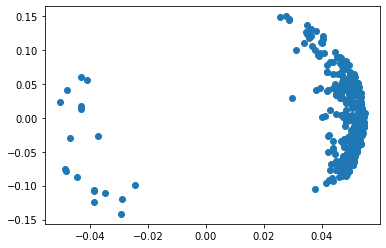

In [123]:
plt.scatter(lds[:,0],lds[:,1])

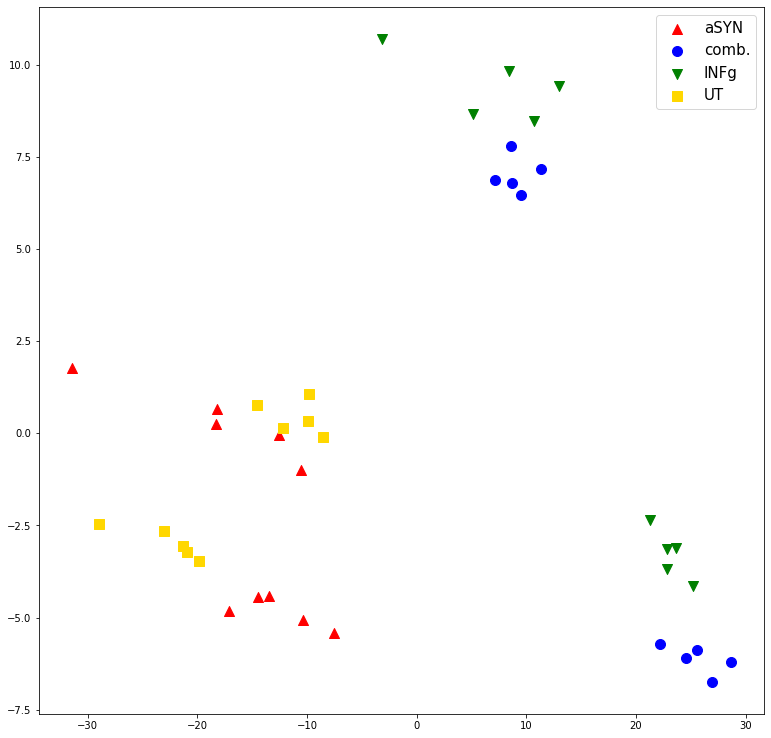

In [112]:
k=1
fig, ax = plt.subplots(figsize=(13,13))
ax.scatter(pls[:10,0],pls[:10,k], marker='^', c='red', s=100)
ax.scatter(pls[10:20,0],pls[10:20,k], marker='o', c='blue', s=100)
ax.scatter(pls[20:30,0],pls[20:30,k], marker='v', c='green', s=100)
ax.scatter(pls[30:,0],pls[30:,k], marker='s', c='gold', s=100)
ax.legend(['aSYN','comb.','INFg','UT'], fontsize=15)


In [113]:
pca = PCA().fit_transform(x)
pca = add_noise(pca, 1)

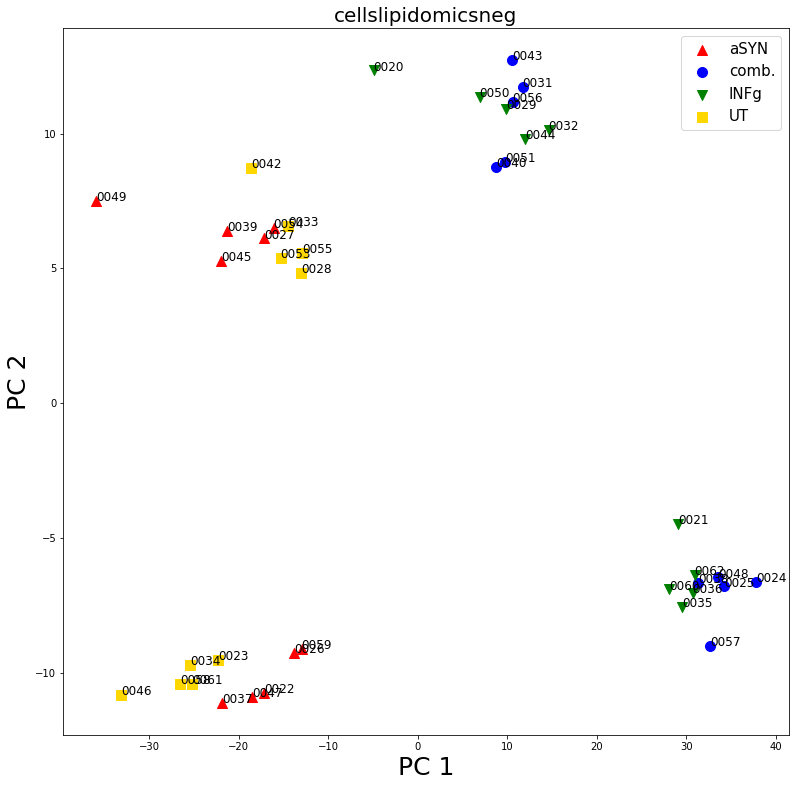

In [114]:
SAVE=False
k=1
fig, ax = plt.subplots(figsize=(13,13))
ax.scatter(pca[:10,0],pca[:10,k], marker='^', c='red', s=100)
ax.scatter(pca[10:20,0],pca[10:20,k], marker='o', c='blue', s=100)
ax.scatter(pca[20:30,0],pca[20:30,k], marker='v', c='green', s=100)
ax.scatter(pca[30:,0],pca[30:,k], marker='s', c='gold', s=100)
ax.legend(['aSYN','comb.','INFg','UT'], fontsize=15)

for i, txt in enumerate(ID):
    ax.annotate(txt, (pca[i,0], pca[i,k]),fontsize=12)
plt.xlabel('PC 1', fontsize=25)
plt.ylabel('PC {}'.format(k+1), fontsize=25)
plt.title(tle, fontsize=20)
plt.show()

if SAVE:
    fig.savefig('../../PDproj/paavo/plots/pca/eps/{}.eps'.format(tle))
    fig.savefig('../../PDproj/paavo/plots/pca/tifs/{}.tif'.format(tle))
    fig.savefig('../../PDproj/paavo/plots/pca/jpeg/{}.jpg'.format(tle))